In [1]:

import sys
sys.path.append("/Users/octavia/Dropbox/SVE_v2/utilities")
sys.path.append("/Users/octavia/Dropbox/SVE_v2/model")

my_modules = ['plot_functions', 
              'input_veg',
              'search_functions']
for mod in my_modules:
    if mod in sys.modules: 
        del sys.modules[mod]

from scipy import signal        
from plot_functions import *
from input_veg import *
from ravel_fxns_RF import *   

# Illustrate how vegetation fields are constructed

[]

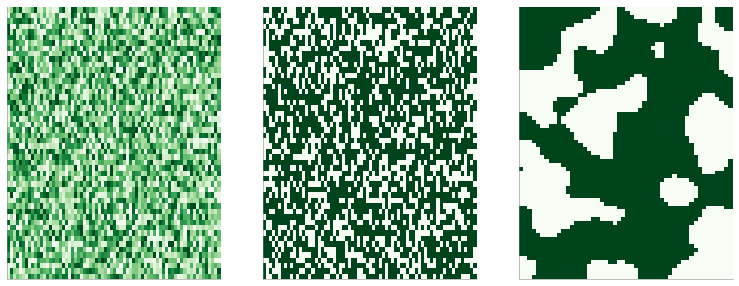

In [2]:
# isotropic
fig = plt.figure(figsize= (13,5))
plt.subplots_adjust(wspace = 0.2)
from scipy.ndimage.filters import gaussian_filter

ncol = 50
nrow = 70

sigma_y = 3
sigma_x = 3

fV = 0.6

ax = plt.subplot(131)
isveg = np.random.rand(ncol, nrow) 
plt.pcolormesh(isveg, cmap = 'Greens')
ax.set_yticks([], [])
ax.set_xticks([], [])

ax = plt.subplot(132)
isveg = np.random.rand(ncol, nrow) 
isveg = isveg  <  fV
plt.pcolormesh(isveg, cmap = 'Greens')
ax.set_yticks([], [])
ax.set_xticks([], [])


ax = plt.subplot(133)

blurred = gaussian_filter(isveg.astype(float), sigma=(sigma_x,sigma_y))
isveg_b = (blurred> np.percentile(blurred, 100*(1-fV))).astype(int)
plt.pcolormesh(isveg_b.T, cmap = 'Greens')
ax.set_yticks([], [])
ax.set_xticks([], [])


(<matplotlib.axes._subplots.AxesSubplot at 0x1a23071450>,
 <matplotlib.collections.QuadMesh at 0x1a231f3710>)

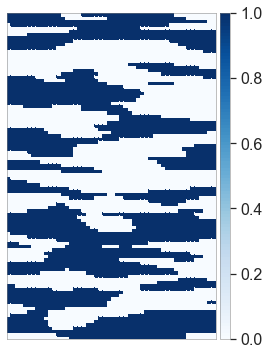

In [3]:
seed = 1 
sigma_x = 1 
sigma_y = 5
fV = 0.5
sim = pd.Series({'p' : 2.0, 'tr' :30, 'Ks' : 8.0, 'So' : 0.15, 'sigma_x': sigma_x,  
                 'sigma_y' : sigma_y,
                 'fV' : fV, 'seed' : seed,
                 'veg' : make_randv(100, 50, fV, sigma_x, sigma_y, seed, 0), 'dx' : 1,})

arraycolor( sim.veg)

In [4]:


Q2 = pd.DataFrame()
fVs = list(np.random.uniform(low=0.1, high=0.9, size=1000))
sigmas = list(np.random.randint(1, 10, 1000))
sigma_scales = list(np.random.randint(-10, 10, 1000))
seed = 0
ncol = 100

for count in range(0,20):
        fV = fVs.pop()
        sigma = sigmas.pop()
        sigma_scale  = sigma_scales.pop()
        count = 0
        count += 1
        if (sigma_scale < 0):                    
            sigma_y = - sigma_scale*sigma
            sigma_x = sigma
        else:   
            sigma_x =  sigma_scale*sigma
            sigma_y = sigma                    
        sim = pd.Series({'sigma_x': sigma_x, 
                         'sigma_y' : sigma_y, 'fV' : fV, 'seed' : seed, 'sigma' : sigma,
                         'sigma_scale' : sigma_scale,
                         'ncol' : ncol,
                         'isvegc' : make_randv(ncol, ncol, fV, sigma_x, sigma_y, seed), 'dx' : 1})
        #sim = get_fourier(sim, dL = 2, w = 80)
        sim['patchL'], sim['patchLB'] = get_patchL(sim.isvegc, 1000) 
        sim['PL'] = np.mean(sim['patchL'])  # pervious length
        sim['patchW'], sim['patchWB'] = get_patchL(sim.isvegc.T, 1000)         
        sim['PW'] = np.mean(sim['patchW']) # pervious width       
        sim['bareL'], sim['bareLV'] = get_patchL(1- sim.isvegc, 1000) 
        sim['IL'] = np.mean(sim['bareL'])  # impervious length        
        sim['bareW'], sim['bareWV'] = get_patchL(1- sim.isvegc.T, 1000) 
        sim['IW'] = np.mean(sim['bareW'])  # pervious width                

        Q2 = Q2.append(sim, ignore_index=True)

Q2['PLoW'] = np.log(Q2['PL']/Q2['PW'])
Q2['ILoW'] = np.log(Q2['IL']/Q2['IW'])


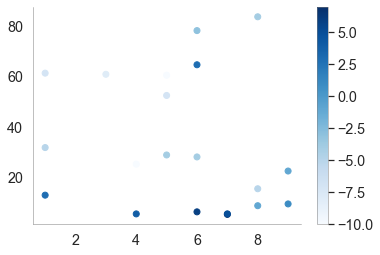

In [5]:
plt.scatter(Q2.sigma, Q2.IL, c = Q2.sigma_scale)
plt.colorbar()

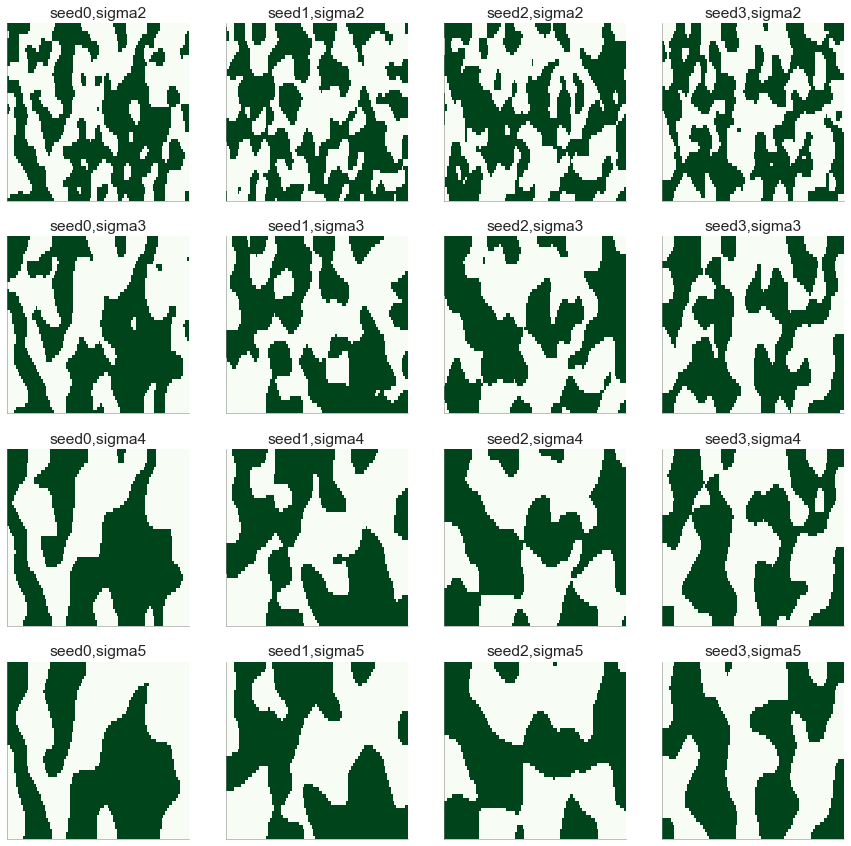

In [6]:
save_to_dir = "/Users/octavia/Dropbox/SVE_v2/model_output/test_veg/veg"
sims ={}
plt.figure(figsize = (15, 15))
count = 0
for sigma in [2, 3,4,5]:
    for seed in [0, 1,2,3]:
        for fV in [.5]:
            count += 1
            sim = pd.Series({'p' : 5.0, 'tr' :30, 'Ks' : 8.0, 'So' : 0.15, 'sigma': sigma, 
                             'fV' : fV, 'seed' : seed,
                             'veg' : make_randv(50, 100, fV, sigma, sigma, seed), 'dx' : 1})

            sims[count] = sim[['sigma', 'seed', 'isvegc', 'fV', 'L80']]
            ax = plt.subplot(4,4,count)
            plt.pcolormesh(sim.veg, cmap = 'Greens')
            name = "seed" + str(seed) + ',sigma' + str( sigma)
            plt.title(name)
            filename = os.path.join(save_to_dir, name + '.npy' )
            np.save(filename, sim.veg)
            ax.set_xticks([], []);
            ax.set_yticks([], []);

In [7]:
dx = 2
So = 0.0

ncol = 100
nrow = 100
m_So = 0.1
m_sigma = 1
params = {"dx" : dx, "So" : So, 
          "ncol" : ncol, "nrow" : nrow,
          "m_So" : m_So, "m_sigma" : m_sigma,          
         }


def gaussian_micro(params):

    dx = params['dx']
    nrow = params['nrow']
    ncol = params['ncol']
    So = params['So']
    m_So = params['m_So']
    m_sigma = params['m_sigma']

    x = np.arange(0, (ncol + 1) * dx - 1e-10, dx)
    y = np.arange(0, (nrow + 1) * dx - 1e-10, dx)

    x, y = np.meshgrid(x, y)
    z_max = So * (np.max(x) - np.min(x))
    z_max = np.linspace(z_max, 0, ncol + 1)
    z = np.tile(z_max, [nrow + 1]).reshape([nrow + 1, ncol + 1])

    np.random.seed(0)

    micro = sp.rand(nrow + 1, ncol + 1) >= 0.5

    micro = micro.astype(float)

    blurred = gaussian_filter(micro.astype(float),
                              sigma=m_sigma)

    Si = (blurred[:, 1:] - blurred[:, :-1]).max()
    blurred = blurred * m_So*dx / Si 
    blurred -= blurred.mean()

    w_width = 5
    window = signal.gaussian(w_width*2, std=2)
    window = np.hstack((window[:w_width], 
                        np.ones(ncol+1-w_width*2),window[-w_width:] ))
    window = np.tile(window, [nrow+1,1])

    y_window = signal.gaussian(w_width*2, std=2)
        
    y_window = np.hstack((y_window[:w_width], 
                        np.ones(nrow+1-w_width*2),y_window[-w_width:] ))
    y_window = np.tile(y_window, [ncol+1,1]).T

    micro = blurred*window*y_window

    z = z + micro

    return z, micro

In [8]:
z, micro = gaussian_micro(params)        

(<matplotlib.axes._subplots.AxesSubplot at 0x1a242030d0>,
 <matplotlib.collections.QuadMesh at 0x1a238d3350>)

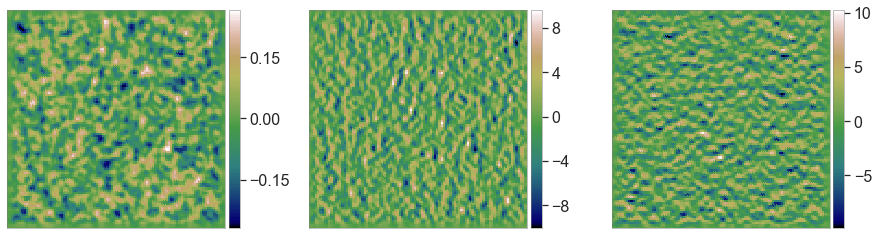

In [9]:
array = micro
fig, axes = plt.subplots(1,3, figsize = (15, 4))
axes = axes.ravel()
plt.subplots_adjust(wspace = 0.3)

ax = axes[0]
arraycolor(array, cmap = 'gist_earth', ax = ax)


ax = axes[1]
x_grad = (array[:, 1:] - array[:, :-1])*100/dx
arraycolor(x_grad, cmap = 'gist_earth', ax = ax)

ax = axes[2]
y_grad = (array[1:] - array[ :-1])*100/dx
arraycolor(y_grad, cmap = 'gist_earth', ax = ax)


In [10]:
asign = np.sign(x_grad[1])
signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
sign_inds = np.where(signchange == 1)[0]

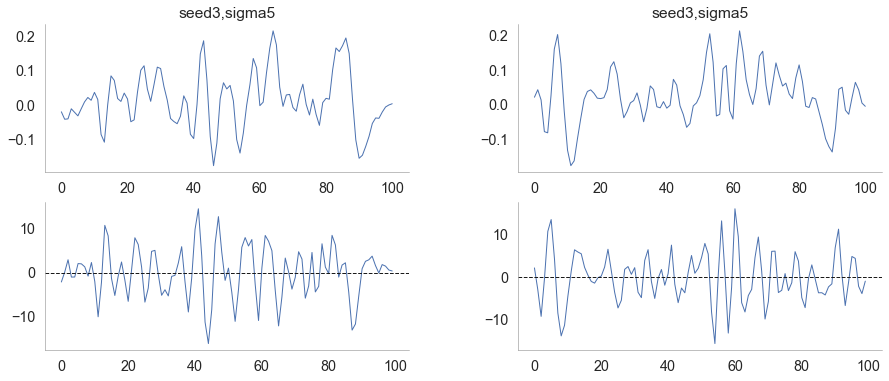

In [11]:
fig, axes = plt.subplots(2,2, figsize = (15, 6))
axes = axes.ravel()
plt.subplots_adjust(wspace = 0.3)

array = micro
ind = 20
ax = axes[0]
ax.plot(array[ind])
ax.set_title(name)

x_grad = np.arctan((array[:, 1:] - array[:, :-1]))*100
signchange[0]

ax = axes[2]
ax.plot(x_grad[ind])
ax.axhline(0, c ='k', ls = '--')
# [ax.axvline(i, c ='k', ls = '--') for i in sign_inds]

ax = axes[1]
ax.plot(array[:, ind])
ax.set_title(name)

y_grad = (array[1:] - array[ :-1])*100
signchange[0]

ax = axes[3]
ax.plot(y_grad[:, ind])
ax.axhline(0, c ='k', ls = '--')


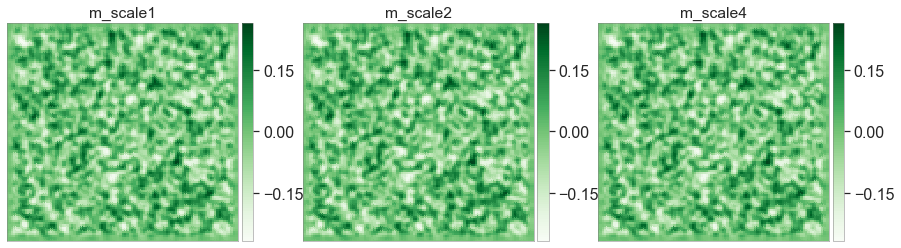

In [14]:

save_to_dir = "/Users/octavia/Dropbox/SVE_v2/model_output/test_topo/topo"
fig, axes = plt.subplots(1,3, figsize = (15, 4))
count = 0

for i, m_scale in enumerate([1, 2,4]):
        ax = axes[i]
        params["m_scale"] = m_scale
        z, micro = gaussian_micro(params)        
        arraycolor(micro, cmap = 'Greens', ax = axes[count])
        name = "m_scale" + str(m_scale) 
        ax.set_title(name)
        filename = os.path.join(save_to_dir, name + '.npy' )
        np.save(filename, micro)
        ax.set_xticks([], []);
        ax.set_yticks([], []);
        count += 1


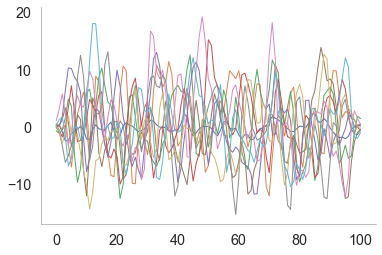

In [15]:
plt.figure()
plt.plot(np.diff(micro, 1)[:, ::10]*100);
